# DA5401 A3: Notebook for Addressing Class Imbalance

Name : Pratyay Piyush Mishra

Roll : DA25E053

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

In [42]:
df = pd.read_csv('creditcard.csv')
print("Shape of the dataset:", df.shape)

Shape of the dataset: (284807, 31)


## Class imbalance

Number of data points for fraud class is a lot lower in the dataset

In [43]:
class_distribution = df['Class'].value_counts()
print("Class distribution:\n", class_distribution)

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [44]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [45]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic regression on original dataset - Baseline model

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [47]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFraudulent transactions in training set:", y_train.sum())
print("Fraudulent transactions in test set:", y_test.sum())

# Train the Logistic Regression classifier (Model 1)
print("\n--- Training Baseline Model (Model 1) ---")
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Evaluate the model's performance on the imbalanced test set
y_pred_baseline = baseline_model.predict(X_test)
print("\nClassification Report for Baseline Model:")
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Fraud', 'Fraud']))

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Fraudulent transactions in training set: 394
Fraudulent transactions in test set: 98

--- Training Baseline Model (Model 1) ---

Classification Report for Baseline Model:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



### Model Evaluation and Choice of Metrics

In this fraud detection scenario, failing to detect a fraudulent transaction (a false negative) is typically much more costly than incorrectly flagging a legitimate transaction as fraudulent (a false positive). Therefore, we are particularly interested in how well the model performs on the minority class (fraudulent transactions). Precision, recall, and F1-score for the 'Fraud' class directly address this by focusing on the model's performance on the instances that matter most from a business perspective. A model with high recall, even if it has slightly lower precision, might be preferred in a fraud detection system to minimize financial losses. The F1-score helps in finding a balance between these two competing objectives.

By examining these minority class metrics, we can gain a much clearer understanding of the model's effectiveness in identifying fraudulent activities, which is the primary goal of this problem.

### GMM-Based Synthetic Sampling vs. SMOTE

Both GMM-based synthetic sampling and SMOTE (Synthetic Minority Over-sampling Technique) are techniques used to address class imbalance in datasets by generating synthetic samples for the minority class. However, they differ fundamentally in how they generate these samples.

**SMOTE:**

SMOTE works by selecting a minority class instance and then finding its k-nearest neighbors. It then generates synthetic samples along the line segments connecting the minority instance to its neighbors. This approach is relatively simple and effective in many cases. However, SMOTE has limitations:

*   It assumes that the minority class instances lie on linear manifolds, which may not always be true.
*   It can generate synthetic samples that are close to the majority class instances, potentially leading to overlapping and noise.
*   It struggles to capture the underlying data distribution when the minority class has multiple sub-groups or complex shapes in the feature space.

**GMM-Based Synthetic Sampling:**

GMM-based synthetic sampling, on the other hand, uses a Gaussian Mixture Model (GMM) to model the distribution of the minority class. A GMM assumes that the data is generated from a mixture of several Gaussian distributions. By fitting a GMM to the minority class data, the method can learn the underlying structure and density of the minority class.

**Why GMM is Theoretically Better:**

GMM is theoretically better at capturing the underlying data distribution, especially when the minority class has multiple sub-groups or complex shapes in the feature space, for the following reasons:

*   **Modeling Complex Distributions:** GMM can model complex, multi-modal distributions by combining multiple Gaussian components. This allows it to capture the nuances of the minority class when it consists of distinct sub-groups.
*   **Density Estimation:** GMM provides a probabilistic model of the data density. This allows for generating synthetic samples that are more representative of the minority class distribution, including areas of lower density.
*   **Flexibility:** GMM is a flexible model that can adapt to various shapes and structures in the data, unlike SMOTE's linear assumption.

In essence, while SMOTE generates synthetic samples based on local linear interpolations, GMM-based synthetic sampling learns a more global and probabilistic representation of the minority class distribution, enabling it to generate more realistic and diverse synthetic samples, particularly in complex scenarios.

# GMM Oversampling dataset

We fit a GMM to the minority class datapoints in our dataset. We determine the optimal number of components (k) for the GMM using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC), and decide to use k = 3

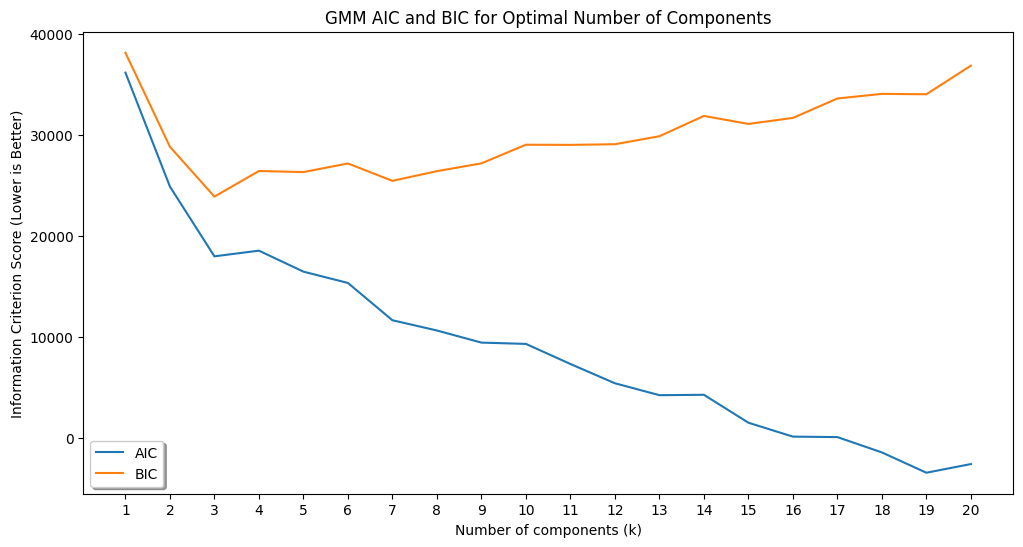

In [48]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
# Isolate minority class data from the training set
X_train_minority = X_train[y_train == 1]

# Determine the optimal number of components (k) for GMM
n_components = np.arange(1, 21)
aic = []
bic = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_minority)
    aic.append(gmm.aic(X_train_minority))
    bic.append(gmm.bic(X_train_minority))

plt.figure(figsize=(12, 6))
plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.title('GMM AIC and BIC for Optimal Number of Components')
plt.xlabel('Number of components (k)')
plt.ylabel('Information Criterion Score (Lower is Better)')
plt.xticks(n_components)
plt.legend(shadow=True)
plt.show()

In [49]:
# Find the optimal number of components based on AIC and BIC
optimal_n_aic = n_components[np.argmin(aic)]
optimal_n_bic = n_components[np.argmin(bic)]

print(f"Optimal number of components based on AIC: {optimal_n_aic}")
print(f"Optimal number of components based on BIC: {optimal_n_bic}")

# Fit GMM with the chosen optimal number of components (you can choose either AIC or BIC)
# Let's use the optimal number of components based on BIC for now
optimal_n = optimal_n_bic
gmm = GaussianMixture(n_components=optimal_n, random_state=42)
gmm.fit(X_train_minority)

print(f"\nGaussian Mixture Model fitted with {optimal_n} components.")

Optimal number of components based on AIC: 19
Optimal number of components based on BIC: 3

Gaussian Mixture Model fitted with 3 components.


### Determining Optimal GMM Components (k)

To find the best number of components (k) for the GMM on minority class data, we used AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).

*   **AIC & BIC:** These metrics balance model fit and complexity. Lower scores are better. BIC penalizes complexity more.

**Process:**

1.  Fitted GMMs with k from 1 to 20 on minority data.
2.  Calculated AIC and BIC for each k.
3.  Plotted scores vs. k.

We chose k=3 based on the BIC plot, which showed a clear minimum, favoring a simpler, more reliable model than AIC.

In [54]:
n_majority = y_train.value_counts()[0]
n_minority = y_train.value_counts()[1]
n_samples_to_generate = n_majority - n_minority

print(f"Original Majority Count: {n_majority}")
print(f"Original Minority Count: {n_minority}")
print(f"Number of synthetic samples to generate: {n_samples_to_generate}")

X_synthetic, y_synthetic_labels = gmm.sample(n_samples_to_generate)
y_synthetic = pd.Series(np.ones(n_samples_to_generate, dtype=int))

# Convert synthetic data to DataFrame with correct column names
X_synthetic_df = pd.DataFrame(X_synthetic, columns=X_train.columns)

# Combine with original training data to create the GMM-balanced dataset
X_train_gmm = pd.concat([X_train, X_synthetic_df], ignore_index=True)
y_train_gmm = pd.concat([y_train, y_synthetic], ignore_index=True)

# Check the new class distribution
print("\nNew class distribution after GMM Oversampling:")
print(y_train_gmm.value_counts())

Original Majority Count: 227451
Original Minority Count: 394
Number of synthetic samples to generate: 227057

New class distribution after GMM Oversampling:
0    227451
1    227451
Name: count, dtype: int64


## CBU + GMM Oversampling dataset

Here, we first create clusters for majority class using KMeans clustering, and use CBU to undersample from those clusters, reducing majority class datapoints. Then we use GMM to add synthetic points for minority class and make samples for both classes equal in number

In [58]:
from imblearn.under_sampling import ClusterCentroids

# Instantiate ClusterCentroids with a ratio of 3:1 for majority to minority class
cc = ClusterCentroids(sampling_strategy={0: n_minority * 3}, random_state=42,estimator = MiniBatchKMeans())

# Undersample the majority class
X_train_cbu, y_train_cbu = cc.fit_resample(X_train, y_train)

print("New class distribution after ClusterCentroids Undersampling:")
print(y_train_cbu.value_counts())

New class distribution after ClusterCentroids Undersampling:
Class
0    1182
1     394
Name: count, dtype: int64


In [61]:
n_extra_cbu = y_train_cbu.value_counts()[0] - y_train_cbu.value_counts()[1]
X_synthetic_minority, _ = gmm.sample(n_extra_cbu)
y_synthetic_class = np.ones(n_extra_cbu, dtype=int)
X_synthetic_minority_df = pd.DataFrame(X_synthetic_minority, columns=X_train.columns)
y_synthetic_minority_s = pd.Series(y_synthetic_class)

X_train_cbu = pd.concat([X_train_cbu, X_synthetic_minority_df], ignore_index=True)
y_train_cbu = pd.concat([y_train_cbu, y_synthetic_minority_s], ignore_index=True)

print(y_train_cbu.value_counts())

0    1182
1    1182
Name: count, dtype: int64


## Training logistic regression models on both synthetic datasets

We now train logistic regression on both GMM based oversampling dataset and the CBU+GMM dataset, and compare which model gives us the best recall, precision and f1-score

In [62]:
# Model 2: Trained on GMM-Oversampled data
model_gmm = LogisticRegression(solver='liblinear', random_state=42)
model_gmm.fit(X_train_gmm, y_train_gmm)
y_pred_gmm = model_gmm.predict(X_test)

print("--- GMM-Oversampled Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gmm, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# Model 3: Trained on Hybrid (CBU + GMM) data
model_hybrid = LogisticRegression(solver='liblinear', random_state=42)
model_hybrid.fit(X_train_cbu, y_train_cbu)
y_pred_hybrid = model_hybrid.predict(X_test)

print("\n--- Hybrid (CBU + GMM) Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hybrid, target_names=['Non-Fraud (0)', 'Fraud (1)']))

--- GMM-Oversampled Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     56864
    Fraud (1)       0.08      0.91      0.15        98

     accuracy                           0.98     56962
    macro avg       0.54      0.95      0.57     56962
 weighted avg       1.00      0.98      0.99     56962


--- Hybrid (CBU + GMM) Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     56864
    Fraud (1)       0.06      0.89      0.11        98

     accuracy                           0.98     56962
    macro avg       0.53      0.93      0.55     56962
 weighted avg       1.00      0.98      0.99     56962



In [67]:
# Organize metrics for plotting
performance_comparison = pd.concat([fraud_baseline_metrics, fraud_gmm_metrics, fraud_hybrid_metrics], ignore_index=True)
performance_comparison['model'] = ['Baseline', 'GMM-Oversampled', 'Hybrid']
performance_comparison = performance_comparison[['model', 'precision', 'recall', 'f1-score']]

print("Performance metrics for the 'Fraud' class:")
display(performance_comparison)

Performance metrics for the 'Fraud' class:


,model,precision,recall,f1-score
0,Baseline,0.83,0.64,0.72
1,GMM-Oversampled,0.08,0.91,0.15
2,Hybrid,0.06,0.89,0.11


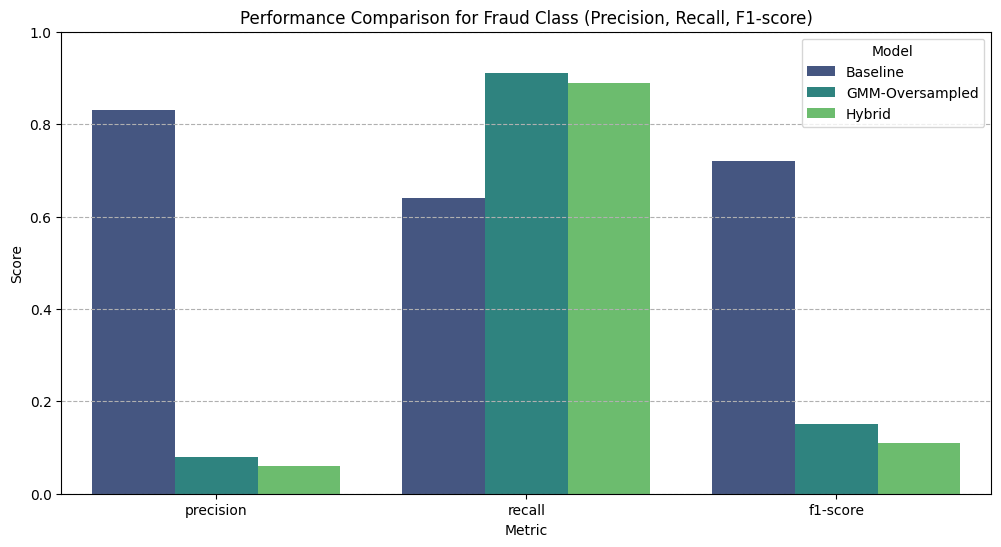

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to long format for easier plotting
performance_melted = performance_comparison.melt(id_vars='model', var_name='metric', value_name='score')

plt.figure(figsize=(12, 6))
sns.barplot(x='metric', y='score', hue='model', data=performance_melted, palette='viridis')
plt.title('Performance Comparison for Fraud Class (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for scores
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.show()

## Final Recommendation

**Recommendation:**

Using GMM for synthetic data generation significantly improves the recall for the minority class (fraudulent transactions) compared to the baseline model. This is crucial for minimizing false negatives in fraud detection.

**Justification:**

1.  **Improved Recall:** Both GMM-oversampled (0.91 recall) and hybrid (0.89 recall) models show substantially higher recall than the baseline (0.64).
2.  **Theoretical Advantage of GMM:** GMM's ability to model complex, multi-modal distributions allows it to generate more realistic synthetic samples, improving the model's ability to identify the minority class.
3.  **Trade-off with Precision:** While recall improves, precision for the 'Fraud' class is lower in GMM-based models. This trade-off is often acceptable in fraud detection where false negatives are more costly than false positives.
4.  **Hybrid Approach:** The hybrid approach (CBU + GMM) shows a slightly lower recall and precision than pure GMM oversampling in this case, but can be beneficial in other scenarios.

In summary, GMM is an effective strategy for addressing class imbalance in this fraud detection problem, leading to better detection of fraudulent transactions due to improved recall, supported by its theoretical ability to model complex distributions.